In [2]:
from imports import *

In [3]:
class polynomialCp:
    def __init__(self, component):
        
        conn = sqlite3.connect('database.db')
        cursor = conn.cursor()

        cursor.execute('''
            SELECT  a1_cold, a2_cold, a3_cold, a4_cold, a5_cold,
                    a1_hot, a2_hot, a3_hot, a4_hot, a5_hot,
                    minColdTemp, maxColdTemp, minHotTemp, maxHotTemp,
                    MolWeight, Hf0
            FROM termoquimica
            WHERE Component = ?
        ''', (component,))

        data = cursor.fetchone()
        conn.close()

        coefs = [(data[i],  data[i+5]) for i in range(5)]
        temps = [(data[i],  data[i+2]) for i in range(10,12)]
        props = data[14:]

        self.a1_cold, self.a1_hot =  coefs[0]
        self.a2_cold, self.a2_hot =  coefs[1]
        self.a3_cold, self.a3_hot =  coefs[2]
        self.a4_cold, self.a4_hot =  coefs[3]
        self.a5_cold, self.a5_hot =  coefs[4]

        self.minColdTemp, self.maxColdTemp = temps[0]
        self.minHotTemp, self.maxHotTemp = temps[1]

        self.MolWeight, self.Hf0 = props

    def cp(self,T):
        if self.minColdTemp <= T < self.maxColdTemp:
            value = self.R*(
                self.a1_cold +
                self.a2_cold * T +
                self.a3_cold * T**2 +
                self.a4_cold * T**3 +
                self.a5_cold * T**4
            )
        elif self.minHotTemp <= T < self.maxHotTemp:
            value = self.R*(
                self.a1_hot +
                self.a2_hot * T +
                self.a3_hot * T**2 +
                self.a4_hot * T**3 +
                self.a5_hot * T**4
            )
        else:
            value = 0
        return value
        


In [10]:
reac = [(5,'H2'),(1,'O2')]
prod = [(2,'H2O'), (3,'H2')]

# Extraer los números


def integration(f,a,b,h):
    return h * ( (f(a) + f(b))/2 + sum([f(a + k*h) for k in range(1, int((b - a)/h))]))

def adiabaticTemp_calc(reac, prod, t0, tGuess, hStep):

    reac_moles = [item[0] for item in reac]
    prod_moles = [item[0] for item in prod]

    reac_comps = [polynomialCp(item[1]) for item in reac]
    prod_comps = [polynomialCp(item[1]) for item in prod]

    hf0_reac = sum([n * r.Hf0 for n,r in zip(reac_moles,reac_comps)])
    hf0_prod = sum([n * p.Hf0 for n,p in zip(prod_moles,prod_comps)])
    
    def heat_balance(t):

        hCp_reac = sum([n * integration(r.cp, 298, t0, hStep) for n,r in zip(reac_moles,reac_comps)])
        hCp_prod = sum([n * integration(p.cp, 298, t,  hStep) for n,p in zip(prod_moles,prod_comps)])

        Q_Disp = hf0_reac + hCp_reac
        Q_Req  = hf0_prod + hCp_prod

        delta = (Q_Disp - Q_Req)
        return delta
    

    def newton_raphson(f, x0, tol=hStep, max_iter=10000, h=hStep):
        """
        Método de Newton-Raphson para encontrar las raíces de una función.

        Args:
        f: función objetivo.
        x0: valor inicial para la raíz.
        tol: tolerancia para la convergencia.
        max_iter: número máximo de iteraciones.
        h: paso pequeño para la derivada numérica.

        Returns:
        La raíz aproximada de la función.
        """
        def fp(f, x, h):
            return (f(x + h) - f(x - h)) / (2 * h)

        x = x0
        for i in range(max_iter):
            fx = f(x)
            dfx = fp(f, x, h)

            if dfx == 0:
                raise ValueError("Derivada nula. El método de Newton-Raphson no puede continuar.")

            x_new = x - fx / dfx

            if abs(x_new - x) < tol:
                return x_new

            x = x_new

        raise ValueError("El método de Newton-Raphson no convergió en el número máximo de iteraciones.")

    prodMol         = sum([n for n in prod_moles])
    tSol            = newton_raphson(heat_balance, tGuess)
    molWeight_prod  = (sum([n * r.MolWeight for n,r in zip(prod_moles,prod_comps)]) / prodMol)*1e-3
    cp_Mass         =  (sum([n * r.cp(tSol) for n,r in zip(prod_moles,prod_comps)]) / prodMol) / molWeight_prod
    R_prod          = 8.31446261815324/molWeight_prod
    cv_Mass         = cp_Mass - R_prod
    gamma           = cp_Mass/(cp_Mass - R_prod)

    return tSol, cp_Mass, molWeight_prod, cp_Mass, cv_Mass, R_prod, gamma

adiabaticTemp_calc(reac, prod, 300, 1000, 1)

(2833.177846183625,
 5283.948034423712,
 0.00841564,
 5283.948034423712,
 4295.970576006617,
 987.9774584170948,
 1.2299777060706696)

In [335]:
from imports import *

class TubularGrain:
    def __init__(self, inputs):
        # Lista de atributos que quieres asignar
        attributes = [
            "rIn_0b", "rOut", "rThrt", "lComb", "lThrt", "rho_b",
            "a", "n", "gamma", "R", "T1", "P0", "delta_r"
        ]
        
        for attr, value in zip(attributes, inputs):
            setattr(self, attr, value)
        
        self.P, self.G, self.M, self.t = self.combTime()

    def combTime(self):

        C = (((np.pi * self.rThrt**2 * self.gamma) / (self.rho_b * self.a * 1e-2)))
        R = np.sqrt( (2/(self.gamma + 1))**((self.gamma - 1)/(self.gamma + 1)) / (self.gamma * self.R * self.T1) )

        rt = np.arange(self.rIn_0b, self.rOut + self.delta_r, self.delta_r)
        size = len(rt)

        P  = np.zeros(size)
        G  = np.zeros(size)
        dt = np.zeros(size)
        m  = np.zeros(size)


        def Ab(ti):
            return 2 * np.pi * self.lComb * rt[ti]

        def M(ti):
            return np.pi * self.rho_b * self.lComb * (self.rOut**2 - rt[ti]**2)

        P[0] = self.P0
        G[0] = Ab(0) * self.rho_b * self.a * P[0]**self.n * 1e-2
        dt[0] = (M(0) - M(1)) / G[0]
        m[0] = M(0)

        def iterCalc(ti):
            P_i = ((C / Ab(ti)) * R)**(1/(self.n - 1))
            G_i = Ab(ti) * self.rho_b * self.a * P_i**self.n * 1e-2
            m_i = M(ti)
            dt_i = (M(ti - 1) - M(ti)) / G_i
            return P_i, G_i, m_i ,dt_i

        for i in range(1, size-1):
            P[i], G[i], m[i], dt[i] = iterCalc(i)
        P[-1], G[-1], m[-1], dt[-1] = self.P0, 0, 0, 0

        return P, G, m, np.cumsum(dt)
    
    def engineGraph(self):
        # Create a figure and axis
        fig, ax = plt.subplots()

        # Plot the outer and inner radius as circles
        outer_circle = plt.Circle((0, 0), self.rOut, color='r', fill=False, label='Outer Radius')
        inner_circle = plt.Circle((0, 0), self.rIn_0b, color='b', fill=False, label='Initial Inner Radius')

        # Add circles to the plot
        ax.add_artist(outer_circle)
        ax.add_artist(inner_circle)

        # Set the limits of the plot
        ax.set_xlim(-self.rOut * 1.1, self.rOut * 1.1)
        ax.set_ylim(-self.rOut * 1.1, self.rOut * 1.1)

        # Set the aspect of the plot to be equal
        ax.set_aspect('equal')

        # Add title and legend
        ax.set_title('Cross-Sectional View of the Rocket Motor')
        ax.legend()

        # Display the plot
        plt.show()
    
    def longitudinalSectionGraph(self):
        # Crear una figura y un eje
        fig, ax = plt.subplots()

        # Definir los radios de empalme
        R1 = 0.1  # Radio de empalme en la unión con el outer boundary
        R2 = 0.1  # Radio de empalme en la salida de la garganta

        # Puntos clave para las curvas de empalme
        l_comb_end = self.lComb
        throat_start_x = l_comb_end + R1
        throat_end_x = l_comb_end + self.lThrt - R2
        exit_x = l_comb_end + self.lThrt

        # Dibujar la sección longitudinal
        # Outer boundary
        ax.plot([0, l_comb_end - R1], [self.rOut, self.rOut], 'r', label='Outer Boundary')
        ax.plot([0, l_comb_end - R1], [-self.rOut, -self.rOut], 'r')

        # Empalme del outer boundary a la garganta
        theta1 = np.linspace(0, np.pi / 2, 100)
        fillet_outer_x = l_comb_end - R1 + R1 * np.sin(theta1)
        fillet_outer_y = self.rOut - R1 + R1 * np.cos(theta1)
        ax.plot(fillet_outer_x, fillet_outer_y, 'r')
        ax.plot(fillet_outer_x, -fillet_outer_y, 'r')

        # Garganta
        ax.plot([throat_start_x, throat_end_x], [self.rThrt, self.rThrt], 'g', label='Throat')
        ax.plot([throat_start_x, throat_end_x], [-self.rThrt, -self.rThrt], 'g')

        # Empalme de la garganta a la salida
        theta2 = np.linspace(-np.pi / 2, 0, 100)
        fillet_exit_x = throat_end_x + R2 * np.cos(theta2)
        fillet_exit_y = self.rThrt + R2 * np.sin(theta2)
        ax.plot(fillet_exit_x, fillet_exit_y, 'g')
        ax.plot(fillet_exit_x, -fillet_exit_y, 'g')

        # Salida
        ax.plot([throat_end_x + R2, exit_x], [0, 0], 'g')

        # Borde interior inicial
        ax.plot([0, self.lComb], [self.rIn_0b, self.rIn_0b], 'b', label='Initial Inner Boundary')
        ax.plot([0, self.lComb], [-self.rIn_0b, -self.rIn_0b], 'b')

        # Sombrear el área del grano
        ax.fill_between([0, self.lComb], self.rIn_0b, self.rOut, color='gray', alpha=0.5)
        ax.fill_between([0, self.lComb], -self.rIn_0b, -self.rOut, color='gray', alpha=0.5)

        # Cámara de combustión
        ax.plot([0, 0], [-self.rOut, self.rOut], 'k', linestyle='--')
        ax.plot([self.lComb, self.lComb], [-self.rOut, self.rOut], 'k', linestyle='--')
        ax.plot([self.lComb + self.lThrt, self.lComb + self.lThrt], [-self.rThrt, self.rThrt], 'k', linestyle='--')

        # Establecer los límites del gráfico
        ax.set_xlim(-0.1 * self.lComb, 1.1 * (self.lComb + self.lThrt))
        ax.set_ylim(-1.1 * self.rOut, 1.1 * self.rOut)

        # Añadir título y leyenda
        ax.set_title('Vista de Sección Longitudinal del Motor Cohete')
        ax.legend()

        # Mostrar el gráfico
        plt.show()


        
                
            
        



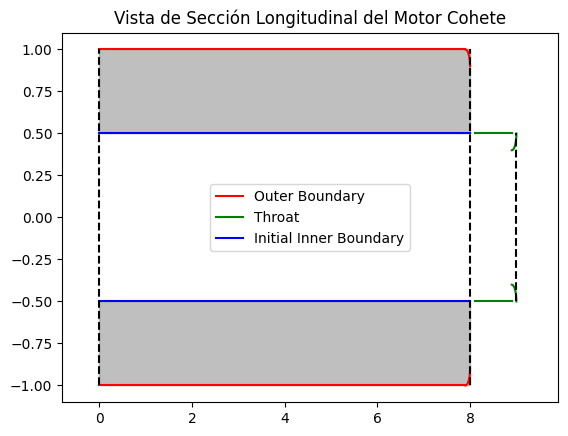

In [336]:
inputs = [0.5, 1, 0.5, 8, 1, 1800, 0.01356, 0.3, 1.15, 223, 1800, 101325, 1e-6]
# Crear una instancia de TubularGrain
grain = TubularGrain(inputs)

# Llamar al método engineGraph para mostrar el dibujo
grain.longitudinalSectionGraph()